# Credit Card Transactions Fraud Detection  

## Venus Qiu

# Introduction

The selected dataset comes from [Kaggle](https://www.kaggle.com/kartik2112/fraud-detection).

The dataset contains simulated credit card transactions with a column identifying fraud. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants. 

Credit card fraud impacts both the customer (through stress, time spent resolving, limited access to expected funds) and the credit card company (through customer retention and reimbursement of customers for lost transactions).  

The goal is to apply the machine learning and data mining techniques to predict, and therefore prevent, fraudulent credit card transactions. 

# Analysis

In this part, I have conducted data preprocessing, EDA, data transformation, Feature Engineering, etc. After all these steps, logistic regression model and different tree-based models are built. Each model's performance will be compared. 

## Install Packages

In [288]:
# main libraries
import pandas as pd
import numpy as np
import time
from numpy import mean, where
from collections import Counter
import statsmodels.api as sm

In [36]:
# visual libraries
import matplotlib.pyplot
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# imblearn libraries
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [190]:
# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.datasets import make_classification
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_auc_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier

## Read Data

In [6]:
fraudTrain = pd.read_csv('fraudTrain.csv')
fraudTest = pd.read_csv('fraudTest.csv')

# Joining fraudTrain and fraudTest datasets
fraud_df = fraudTrain.append(fraudTest)
#fraud_df.head()

In [7]:
print(fraud_df.shape)

(1852394, 23)


In [8]:
fraud_df.head()

Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48.8878 -118.2105   
2  Sanchez      M      594 White Dale Suite 530  ...  42.1808 -112.2620   
3    White      M   9443 Cynthia Court Apt. 038  ...  46.2306 -112.1138   
4   Garcia      M              408 Bradley Rest  ...  38.4207  -79.4629   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educational needs teacher  1978-06-21   
2      4154        Nature conservation officer  1962-01-19   
3      1939                    Patent attorney  1967-01-12   
4        99     Dance movement psychotherapist  1986-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 23 columns]

## Data Preprocessing

### Checking for missing values

In [9]:
fraud_df.isnull().any().sum()

0

### Checking for data types

In [10]:
fraud_df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

### Checking for unique values

In [11]:
fraud_df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

### Data formatting

In [12]:
fraud_df['trans_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
fraud_df['trans_date'] = fraud_df['trans_datetime'].dt.date

In [13]:
# Converting dob to age 
## To parse all datetime columns in advance
fraud_df['dob'] = pd.to_datetime(fraud_df['dob'], errors='coerce')

now = pd.to_datetime('now')

## Create a new column age
fraud_df['dob']=(now.year - fraud_df['dob'].dt.year) - ((now.month - fraud_df['dob'].dt.month) < 0)

fraud_df = fraud_df.rename(columns={'dob': 'age'})

In [14]:
fraud_df.head(3)

Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   

                          merchant       category     amt      first     last  \
0       fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer    Banks   
1  fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie     Gill   
2             fraud_Lind-Buckridge  entertainment  220.11     Edward  Sanchez   

  gender                        street  ... city_pop  \
0      F                561 Perry Cove  ...     3495   
1      F  43039 Riley Greens Suite 393  ...      149   
2      M      594 White Dale Suite 530  ...     4154   

                                 job  age                         trans_num  \
0          Psychologist, counselling   33  0b242abb623afc578575680df30655b9   
1  Special educational needs teacher   42  1f76529f8574734946361c461b024d99   
2        Nature conservation officer   59  a1a22d70485983eac12b5b88dad1cf95   

    unix_time  merch_lat  merch_long  is_fraud      trans_datetime  trans_date  
0  1325376018  36.011293  -82.048315         0 2019-01-01 00:00:18  2019-01-01  
1  1325376044  49.159047 -118.186462         0 2019-01-01 00:00:44  2019-01-01  
2  1325376051  43.150704 -112.154481         0 2019-01-01 00:00:51  2019-01-01  

[3 rows x 25 columns]

## Exploratory Data Analysis

### Transaction Volume by Date

In [15]:
trans_count_by_date = fraud_df['trans_date'].value_counts().sort_index().reset_index()
trans_count_by_date.columns = ['trans_date','count']

Text(0, 0.5, 'Volume')

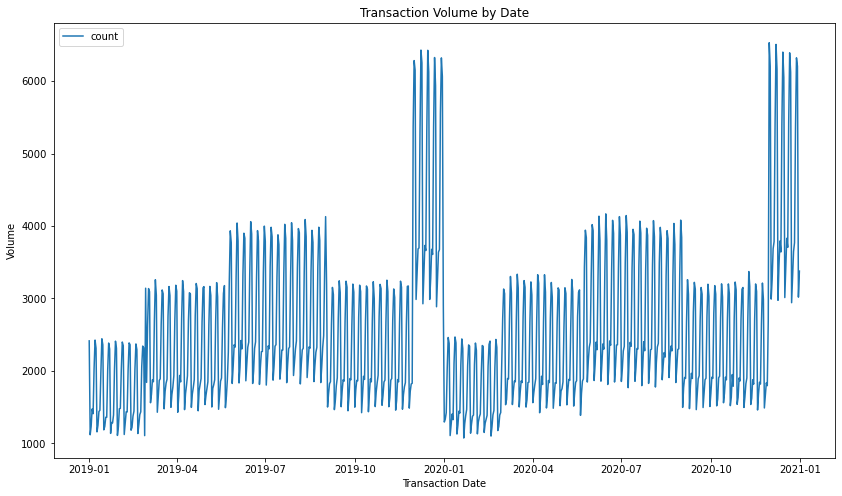

In [16]:
plt = trans_count_by_date.plot.line(x='trans_date', y='count', figsize=(14, 8), title= 'Transaction Volume by Date')
plt.set_xlabel('Transaction Date')
plt.set_ylabel('Volume')

### Volume by Merchant

Text(0, 0.5, 'Volume')

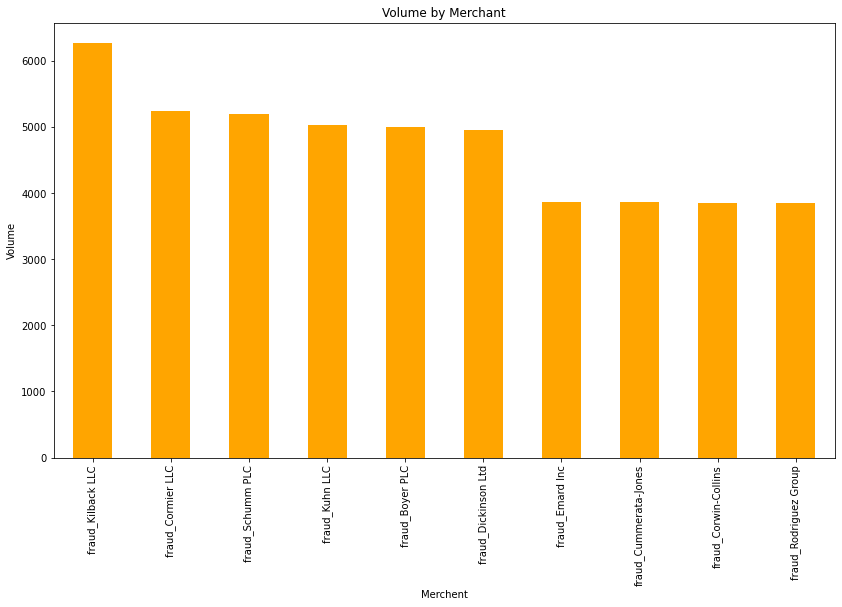

In [17]:
plt = pd.value_counts(fraud_df['merchant']).nlargest(10).plot.bar(figsize=(14, 8), color='orange', title= 'Volume by Merchant')
plt.set_xlabel('Merchent')
plt.set_ylabel('Volume')

### Volume by Category

Text(0, 0.5, 'Category')

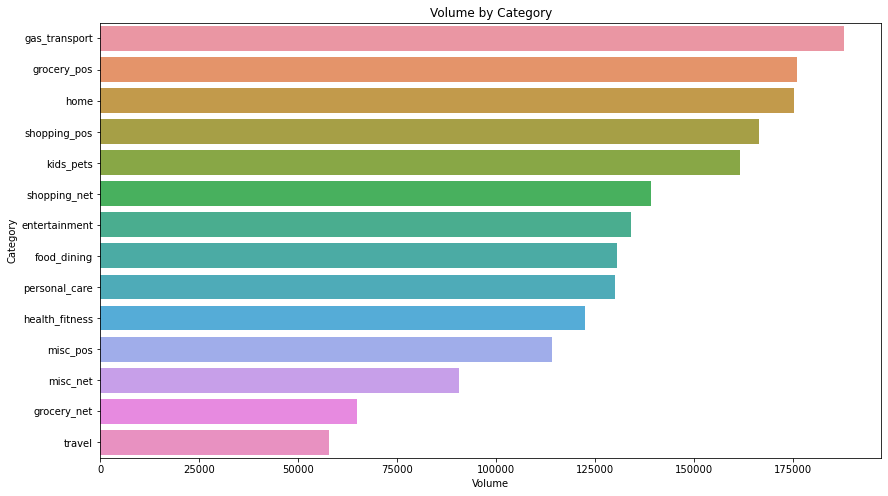

In [18]:
fig = matplotlib.pyplot.subplots(figsize=(14, 8))
category = sns.countplot(y='category', data=fraud_df, order= fraud_df['category'].value_counts().index)
category.set_title('Volume by Category')
category.set_xlabel('Volume')
category.set_ylabel('Category')

### Amount by Category Pie Chart

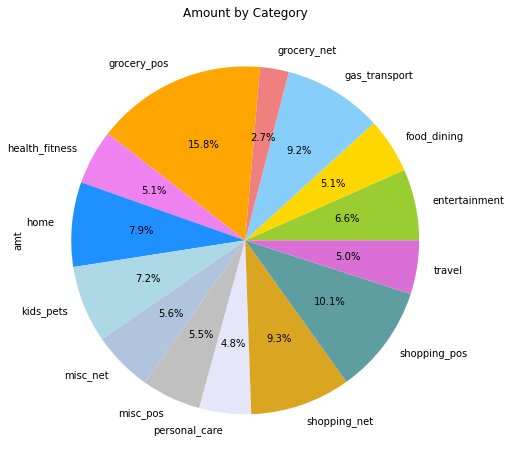

In [19]:
cs = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','orange','violet',
        'dodgerblue', 'lightblue','lightsteelblue','silver', 'lavender','goldenrod',
        'cadetblue','orchid']
category_amt = fraud_df.groupby('category')['amt'].sum()
category_amt.plot.pie(autopct="%.1f%%", colors=cs, figsize=(8, 8), title= 'Amount by Category')

### Boxplot of Amount

Text(0.5, 1.0, 'Boxplot of Amount')

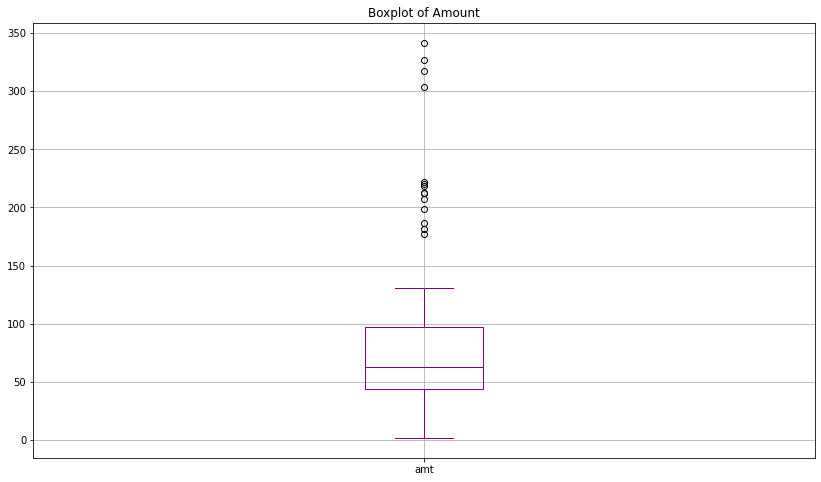

In [20]:
plt=fraud_df.head(100).boxplot(column='amt', figsize=(14, 8),color= 'purple')
plt.set_title('Boxplot of Amount')

### Boxplot of Amount by Gender

Text(0.5, 1.0, 'Amount by Gender')

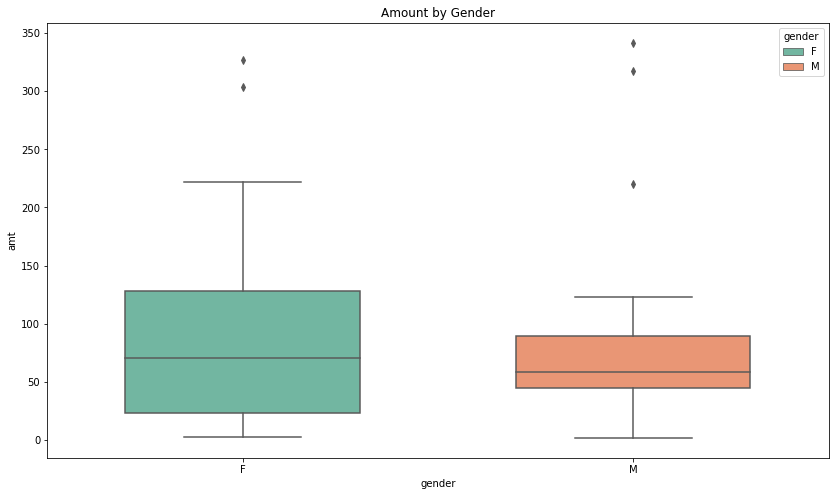

In [21]:
fig = matplotlib.pyplot.subplots(figsize=(14, 8))
gender_amt = pd.DataFrame(fraud_df.head(100), columns = ['amt', 'gender'])
ga=sns.boxplot(y='amt', x='gender', data=gender_amt, hue='gender', dodge=False, width = 0.6, palette= 'Set2')
ga.set_title('Amount by Gender')

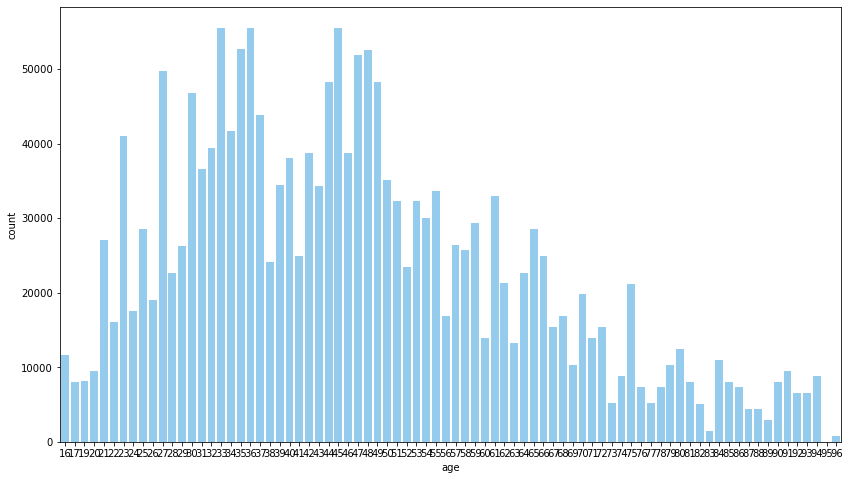

In [22]:
fig = matplotlib.pyplot.subplots(figsize=(14, 8))
sns.countplot(x= 'age',data=fraud_df, color = 'lightskyblue')

## Data Transformation

In [23]:
fraud_df = fraud_df.drop(columns=['Unnamed: 0','trans_date_trans_time', 'cc_num', 'merchant','first', 'last',
       'street', 'city', 'state', 'zip', 'lat', 'long','job','trans_num', 'unix_time', 'merch_lat', 'merch_long','trans_datetime','trans_date'])

In [24]:
fraud_df.head(10)

category     amt gender  city_pop  age  is_fraud
0       misc_net    4.97      F      3495   33         0
1    grocery_pos  107.23      F       149   42         0
2  entertainment  220.11      M      4154   59         0
3  gas_transport   45.00      M      1939   54         0
4       misc_pos   41.96      M        99   35         0
5  gas_transport   94.63      F      2158   59         0
6    grocery_net   44.54      F      2691   27         0
7  gas_transport   71.65      M      6018   73         0
8       misc_pos    4.27      F      1472   80         0
9    grocery_pos  198.39      F    151785   47         0

In [25]:
print(fraud_df.shape)

(1852394, 6)


### Encoding

In [26]:
X_cat = fraud_df.copy()
X_cat = fraud_df.select_dtypes(include=['object'])
X_enc = X_cat.copy()
print(X_enc)

              category gender
0             misc_net      F
1          grocery_pos      F
2        entertainment      M
3        gas_transport      M
4             misc_pos      M
...                ...    ...
555714  health_fitness      M
555715       kids_pets      M
555716       kids_pets      F
555717          travel      M
555718   entertainment      M

[1852394 rows x 2 columns]


In [27]:
# OneHotEncoding
X_enc = pd.get_dummies(X_enc, columns=['category','gender'])
fraud_df = fraud_df.drop(['category','gender'],axis=1)

In [28]:
data = pd.concat([fraud_df,X_enc], axis=1)
data.head()

amt  city_pop  age  is_fraud  category_entertainment  \
0    4.97      3495   33         0                       0   
1  107.23       149   42         0                       0   
2  220.11      4154   59         0                       1   
3   45.00      1939   54         0                       0   
4   41.96        99   35         0                       0   

   category_food_dining  category_gas_transport  category_grocery_net  \
0                     0                       0                     0   
1                     0                       0                     0   
2                     0                       0                     0   
3                     0                       1                     0   
4                     0                       0                     0   

   category_grocery_pos  category_health_fitness  category_home  \
0                     0                        0              0   
1                     1                        0              0   
2                     0                        0              0   
3                     0                        0              0   
4                     0                        0              0   

   category_kids_pets  category_misc_net  category_misc_pos  \
0                   0                  1                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  1   

   category_personal_care  category_shopping_net  category_shopping_pos  \
0                       0                      0                      0   
1                       0                      0                      0   
2                       0                      0                      0   
3                       0                      0                      0   
4                       0                      0                      0   

   category_travel  gender_F  gender_M  
0                0         1         0  
1                0         1         0  
2                0         0         1  
3                0         0         1  
4                0         0         1

In [29]:
data.shape

(1852394, 20)

### Take a look at column 'is_fraud'
In the column 'is_fraud', data are Labeled as 0's and 1's.
0 = non fraud, 1 = fraud

In [30]:
All = data.shape[0]
fraud = data[data['is_fraud'] == 1]
nonFraud = data[data['is_fraud'] == 0]

a = len(fraud)/All
b = len(nonFraud)/All

print('frauds :',round(a,2)*100,'%')
print('non frauds :',round(b,2)*100,'%')

frauds : 1.0 %
non frauds : 99.0 %


### Standardize the data

In [31]:
features = ['amt', 'city_pop', 'age', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_F', 'gender_M']
target = ['is_fraud']
# Separating out the features
x = data.loc[:, features].values
# Separating out the target
y = data.loc[:,target].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

### Principal Component Analysis

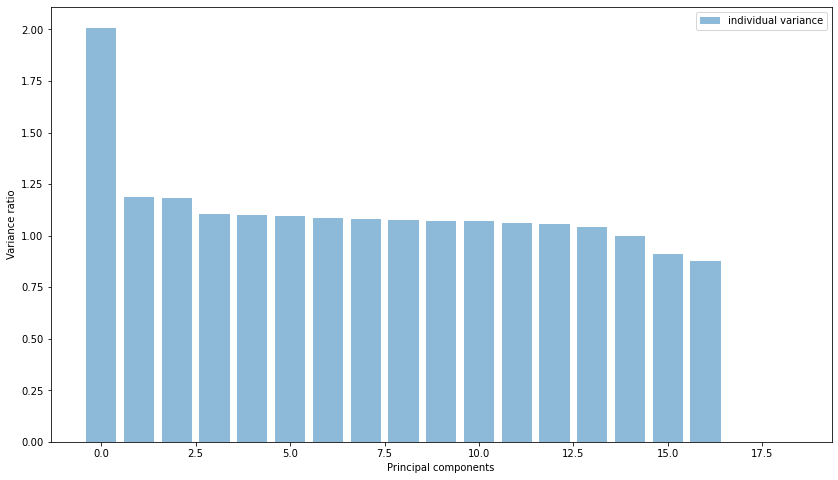

In [39]:
pca = PCA()
pca.fit_transform(x)
pca_variance = pca.explained_variance_

plt.figure(figsize=(14, 8))
plt.bar(range(19), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [40]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
principal_df

principal component 1  principal component 2
0                    -1.314083               0.291913
1                    -1.164212               1.924749
2                     1.725811               0.313263
3                     1.551467              -1.219630
4                     1.566169               0.088302
...                        ...                    ...
1852389               1.564096              -0.406015
1852390               1.557621              -0.160636
1852391              -1.271259              -0.444220
1852392               1.661693               0.631362
1852393               1.709719               0.120879

[1852394 rows x 2 columns]

In [41]:
fraud = pd.DataFrame(data=y, columns = ['is_fraud'])
final_df = pd.concat([principal_df, fraud[['is_fraud']]], axis = 1)
final_df

principal component 1  principal component 2  is_fraud
0                    -1.314083               0.291913         0
1                    -1.164212               1.924749         0
2                     1.725811               0.313263         0
3                     1.551467              -1.219630         0
4                     1.566169               0.088302         0
...                        ...                    ...       ...
1852389               1.564096              -0.406015         0
1852390               1.557621              -0.160636         0
1852391              -1.271259              -0.444220         0
1852392               1.661693               0.631362         0
1852393               1.709719               0.120879         0

[1852394 rows x 3 columns]

In [42]:
principal_df.shape

(1852394, 2)

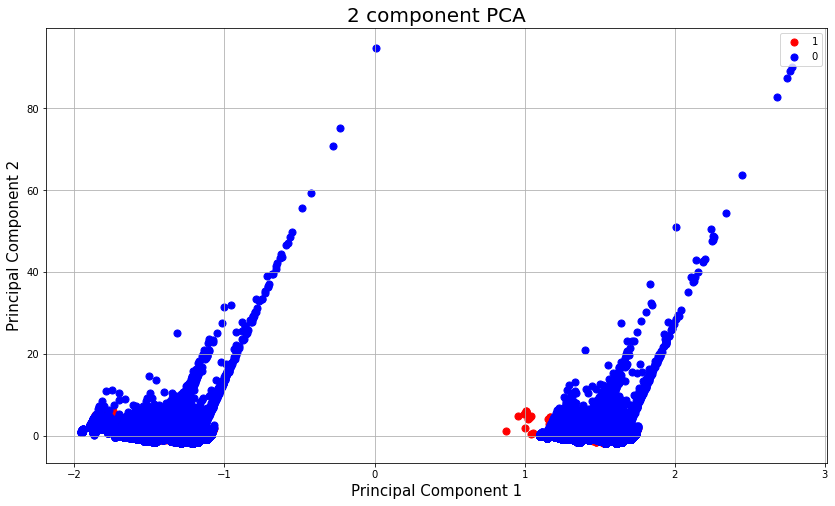

In [43]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['is_fraud'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Data splitting

In [201]:
count = len(fraud_df)
train = data[:count]
test = data[count:]
x = train.drop(['is_fraud'], axis=1)
y = train['is_fraud'].astype('int')
test = test.drop(['is_fraud'], axis=1)

x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.3,random_state=123)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1296675, 19)
(1296675,)
(555719, 19)
(555719,)


## Resampling: SMOTE and Random Undersampling

Resampling methods are designed to add or remove samples from the training dataset in order to change the class distribution. Once the class distributions are more balanced, the suite of standard machine learning classification algorithms can be fit successfully on the transformed datasets.

Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class.

Here, I use oversampling to duplicate or create new synthetic examples in the minority class which is when is_fraud = 1. 

SMOTE should only be done in the training data, but test on the original testing data set since the latter reflects the real-world distribution of majority and minority class samples. That's why I apply SMOTE after data splitting.

Counter({0: 99000, 1: 1000})
Counter({0: 19800, 1: 9900})


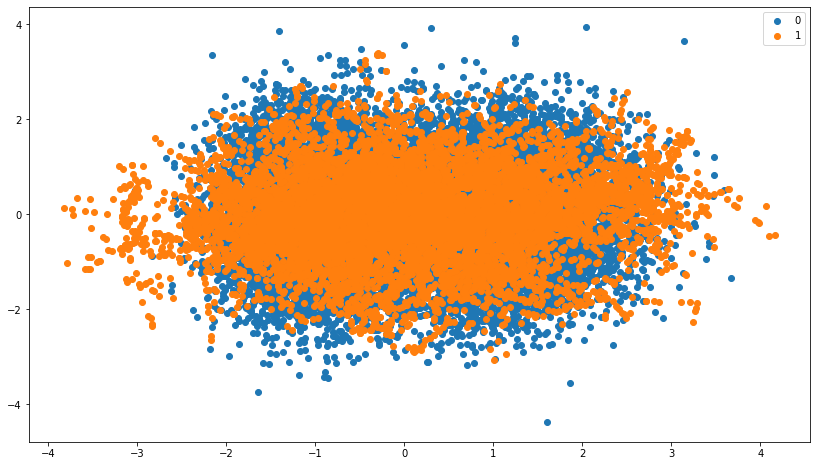

In [202]:
# Oversample with SMOTE and random undersample for imbalanced dataset
# Define dataset
x_train1, y_train1 = make_classification(n_samples=100000, n_features=19, n_redundant=2, n_clusters_per_class=2, 
                           weights=[0.99], flip_y=0, random_state=1)

# Summarize class distribution
counter = Counter(y_train1)
print(counter)

# Define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_train1, y_train1 = pipeline.fit_resample(x_train1, y_train1)

# Summarize the new class distribution
counter = Counter(y_train1)
print(counter)

# Scatter plot of examples by class label
plt.figure(figsize=(14, 8))
for label, _ in counter.items():
    row_ix = where(y_train1 == label)[0]
    plt.scatter(x_train1[row_ix, 0], x_train1[row_ix, 1], label=str(label))

plt.legend()
plt.show()

## Correlation Matrix

In [63]:
corrMatrix = data.corr()
#print (corrMatrix)

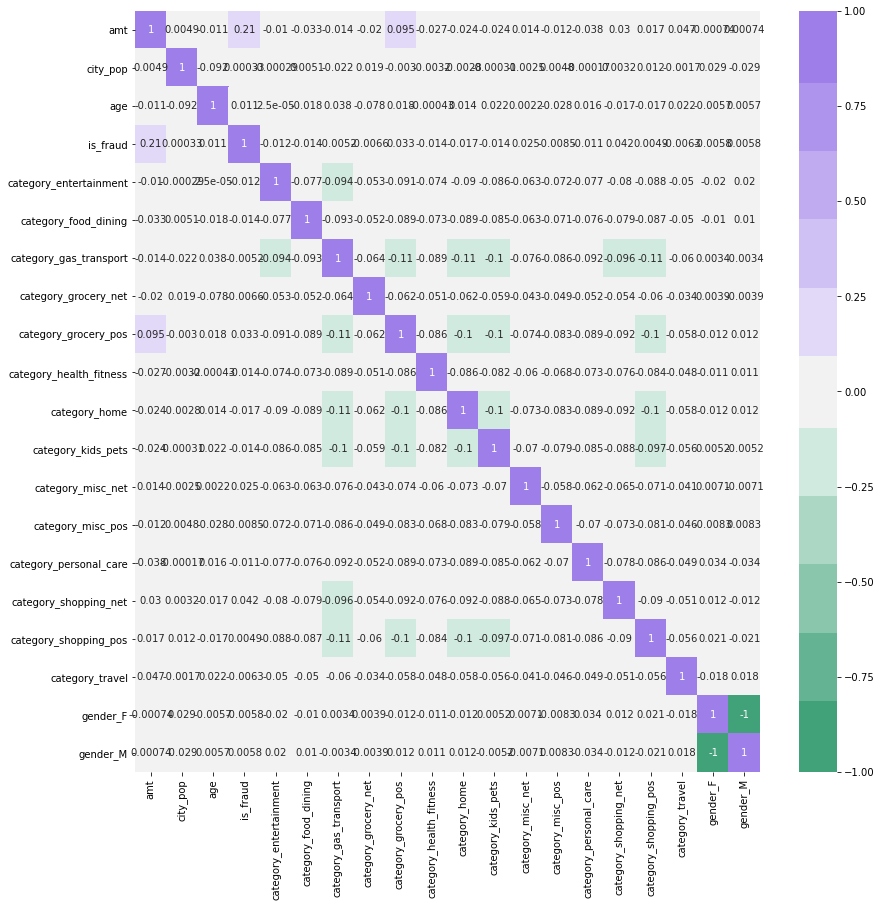

In [64]:
plt.figure(figsize=(14, 14))
#cmap = sns.diverging_palette(250, 30, l=65, as_cmap=True)
cmap =  sns.diverging_palette(150, 275, s=80, l=60, n=11)
sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center= 0, cmap=cmap)
plt.show()

## Logistic Regression

In [307]:
LR=LogisticRegression(penalty='l2', dual=False, tol=0.2, C=1.0, fit_intercept=True, intercept_scaling=1, 
                      class_weight='balanced', random_state=24, solver='sag', max_iter=100, multi_class='auto', 
                      warm_start=True, n_jobs=2)

LR.fit(x_train, y_train)
LR.score(x_train, y_train)

LR_pred = LR.predict(x_test)

# Accuracy Score on test dataset
LR_accuracy = metrics.accuracy_score(y_test, LR_pred)
print("Accuracy:", round(LR_accuracy,2)*100,'%')

LR_probs = LR.predict_proba(x_test)[:, 1]

# Calculate roc auc
LR_roc_value = roc_auc_score(y_test, LR_probs)
print('\nROC AUC : ', round(LR_roc_value,2))

Accuracy: 70.0 %

ROC AUC :  0.68


In [309]:
logit_model=sm.Logit(y_train1,x_train1)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.193255
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.696     
Dependent Variable: y                AIC:              11513.3270
Date:               2021-03-02 21:46 BIC:              11654.4084
No. Observations:   29700            Log-Likelihood:   -5739.7   
Df Model:           16               LL-Null:          -18904.   
Df Residuals:       29683            LLR p-value:      0.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
     Coef.    Std.Err.     z    P>|z|      [0.025       0.975]   
-----------------------------------------------------------------
x1   0.7686 520984.8728  0.0000 1.0000 -1021110.8186 1021112.3559
x2   0.0633      0.0257  2.4653 0.0137        0.0130       0.1137
x3   0.0865      0.0261  3.3143 0.00

/Users/venusqiu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


### Confusion Matrix

Confusion matrix : 
 [[385148 167675]
 [  1211   1685]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82    552823
           1       0.01      0.58      0.02      2896

    accuracy                           0.70    555719
   macro avg       0.50      0.64      0.42    555719
weighted avg       0.99      0.70      0.82    555719



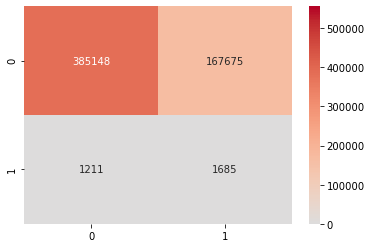

In [299]:
# confusion matrix
LRmatrix = confusion_matrix(y_test, LR_pred)
print('Confusion matrix : \n',LRmatrix)

# classification report for precision, recall f1-score and accuracy
LRmatrix1 = classification_report(y_test,LR_pred)
print('Classification report : \n',LRmatrix1)

sns.heatmap(LRmatrix, annot=True, fmt=".0f", vmin=0, vmax=555719, center= 0, cmap='coolwarm')
plt.show()

## Tree-based Models

## Decision Tree

In [223]:
# Train Decision Tree Model
DT = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3, max_features = 'auto', 
                                 random_state=24) 

DT.fit(x_train1, y_train1)
DT.score(x_train1, y_train1)

# Predict Output
DT_pred = DT.predict(x_test1)

# Accuracy Score on test dataset
DT_accuracy = metrics.accuracy_score(y_test1, DT_pred)

print("Accuracy:", round(DT_accuracy,2)*100,'%')

DT_probs = DT.predict_proba(x_test1)[:, 1]

# Calculate roc auc
DT_roc_value = roc_auc_score(y_test1, DT_probs)
print('\nROC AUC : ', round(DT_roc_value,2))

Accuracy: 99.0 %

ROC AUC :  0.5


### Confusion Matrix

Confusion matrix : 
 [[368563      0]
 [  1916      0]]
Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    368563
           1       0.00      0.00      0.00      1916

    accuracy                           0.99    370479
   macro avg       0.50      0.50      0.50    370479
weighted avg       0.99      0.99      0.99    370479



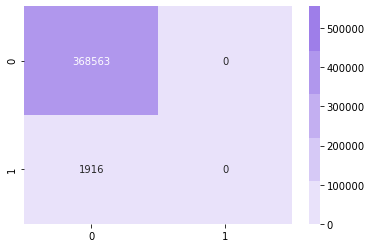

In [298]:
# confusion matrix
DTmatrix = confusion_matrix(y_test1, DT_pred)
print('Confusion matrix : \n',DTmatrix)

# classification report for precision, recall f1-score and accuracy
DTmatrix1 = classification_report(y_test1,DT_pred)
print('Classification report : \n',DTmatrix1)

cmap =  sns.diverging_palette(150, 275, s=80, l=60, n=10)
sns.heatmap(DTmatrix, annot=True, fmt=".0f", vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

### Feature Importances

In [225]:
# Extract feature importances
DT_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': DT.feature_importances_}).\
                    sort_values('importance', ascending = False)
DT_Feature_Imp.head()

features  importance
2                    age    0.385490
12     category_misc_pos    0.228078
18              gender_M    0.217410
17              gender_F    0.162274
7   category_grocery_pos    0.006748

### Visualization of Decision Tree

In [226]:
fig = plt.figure(figsize=(16,10), dpi=900)
treeplot = tree.plot_tree(DT, 
                   feature_names=features,  
                   class_names=['0','1'],
                   filled=True)

## Random Forest

In [230]:
# Train Random Forest Model
RF = RandomForestClassifier(n_estimators=800, bootstrap = True, oob_score = True, n_jobs=1, criterion= 'gini',
                            max_depth=3, max_features = 'auto', random_state= 24)
RF.fit(x_train1, y_train1)

# number of trees used
print('Number of Trees used : ', RF.n_estimators)

# Predict Output
RF_pred = RF.predict(x_test1)

# Accuracy Score on test dataset
RF_accuracy = accuracy_score(y_test1,RF_pred)
print('Accuracy: %.2f%%' % (RF_accuracy * 100.0))

RF_probs = RF.predict_proba(x_test1)[:, 1]

# Calculate roc auc
RF_roc_value = roc_auc_score(y_test1, RF_probs)
print('\nROC AUC : ', round(RF_roc_value,2))

Number of Trees used :  800
Accuracy: 92.89%

ROC AUC :  0.48


### Confusion Matrix

Confusion matrix : 
 [[344096  24467]
 [  1890     26]]
Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    368563
           1       0.00      0.01      0.00      1916

    accuracy                           0.93    370479
   macro avg       0.50      0.47      0.48    370479
weighted avg       0.99      0.93      0.96    370479



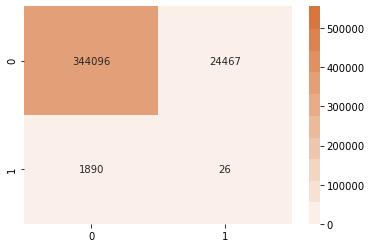

In [231]:
# confusion matrix
RFmatrix = confusion_matrix(y_test1, RF_pred)
print('Confusion matrix : \n',RFmatrix)

# classification report for precision, recall f1-score and accuracy
RFmatrix1 = classification_report(y_test1,RF_pred)
print('Classification report : \n',RFmatrix1)

cmap =  sns.diverging_palette(250, 30, s=80, l=60, n=20)
sns.heatmap(RFmatrix, annot=True,fmt=".0f", vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

### Feature Importances

In [232]:
# Extract feature importances
RF_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': RF.feature_importances_}).\
                    sort_values('importance', ascending = False)
RF_Feature_Imp.head()

features  importance
8   category_health_fitness    0.509861
18                 gender_M    0.305016
0                       amt    0.059537
15    category_shopping_pos    0.056506
2                       age    0.022695

### Visualization of Random Forest

In [233]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (16,10), dpi=800)
tree.plot_tree(RF.estimators_[50],
               feature_names = features, 
               class_names=['0','1'],
               filled = True);

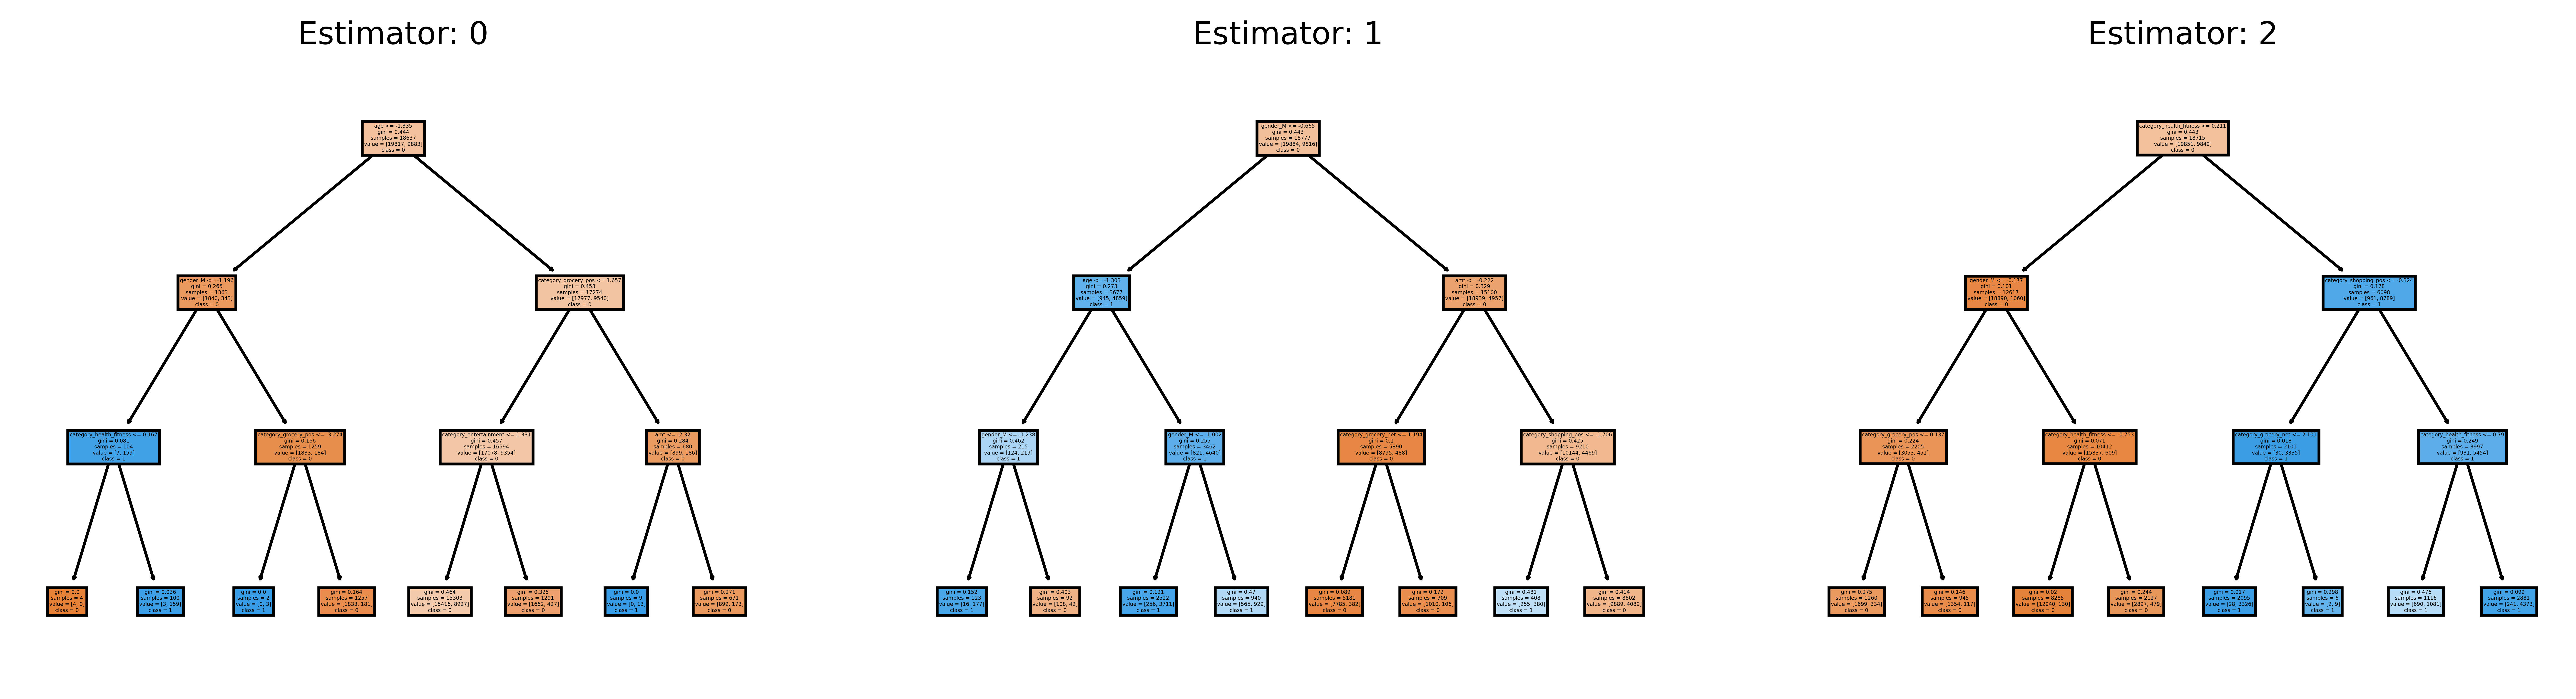

In [234]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (16,4), dpi=900)
for index in range(0, 3):
    tree.plot_tree(RF.estimators_[index],
                   feature_names = features, 
                   class_names=['0','1'],
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

## Gradient Boosting

In [247]:
GBM = GradientBoostingClassifier(n_estimators=800, max_depth=4, loss='exponential', learning_rate=0.5,
                                 criterion='mse', min_weight_fraction_leaf=0.25, min_impurity_decrease=0.25,
                                 random_state=20, max_features='log2', warm_start=True)
GBM.fit(x_train1,y_train1)

# number of trees used
print('Number of Trees used : ', GBM.n_estimators)

# Predict Output
GBM_pred = GBM.predict(x_test1)

# Accuracy Score on test dataset
GBM_accuracy = accuracy_score(y_test1,GBM_pred)
print('Accuracy: %.2f%%' % (GBM_accuracy * 100.0))

GBM_probs = GBM.predict_proba(x_test1)[:, 1]

# Calculate roc auc
GBM_roc_value = roc_auc_score(y_test1, GBM_probs)
print('\nROC AUC : ', round(GBM_roc_value,2))

Number of Trees used :  800
Accuracy: 92.89%

ROC AUC :  0.47


### Confusion Matrix

Confusion matrix : 
 [[344096  24467]
 [  1890     26]]
Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    368563
           1       0.00      0.01      0.00      1916

    accuracy                           0.93    370479
   macro avg       0.50      0.47      0.48    370479
weighted avg       0.99      0.93      0.96    370479



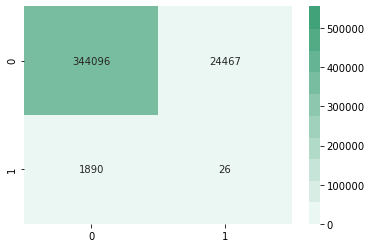

In [248]:
# confusion matrix
GBMmatrix = confusion_matrix(y_test1, GBM_pred)
print('Confusion matrix : \n',GBMmatrix)

# classification report for precision, recall f1-score and accuracy
GBMmatrix1 = classification_report(y_test1,GBM_pred)
print('Classification report : \n',GBMmatrix1)

cmap =  sns.diverging_palette(180, 150, s=80, l=60, n=20)
sns.heatmap(GBMmatrix, annot=True, fmt=".0f", vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

### Feature Importances

In [249]:
# Extract feature importances
GBM_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': GBM.feature_importances_}).\
                    sort_values('importance', ascending = False)
GBM_Feature_Imp.head()

features  importance
8   category_health_fitness         1.0
0                       amt         0.0
10       category_kids_pets         0.0
17                 gender_F         0.0
16          category_travel         0.0

### Visualization of GBM

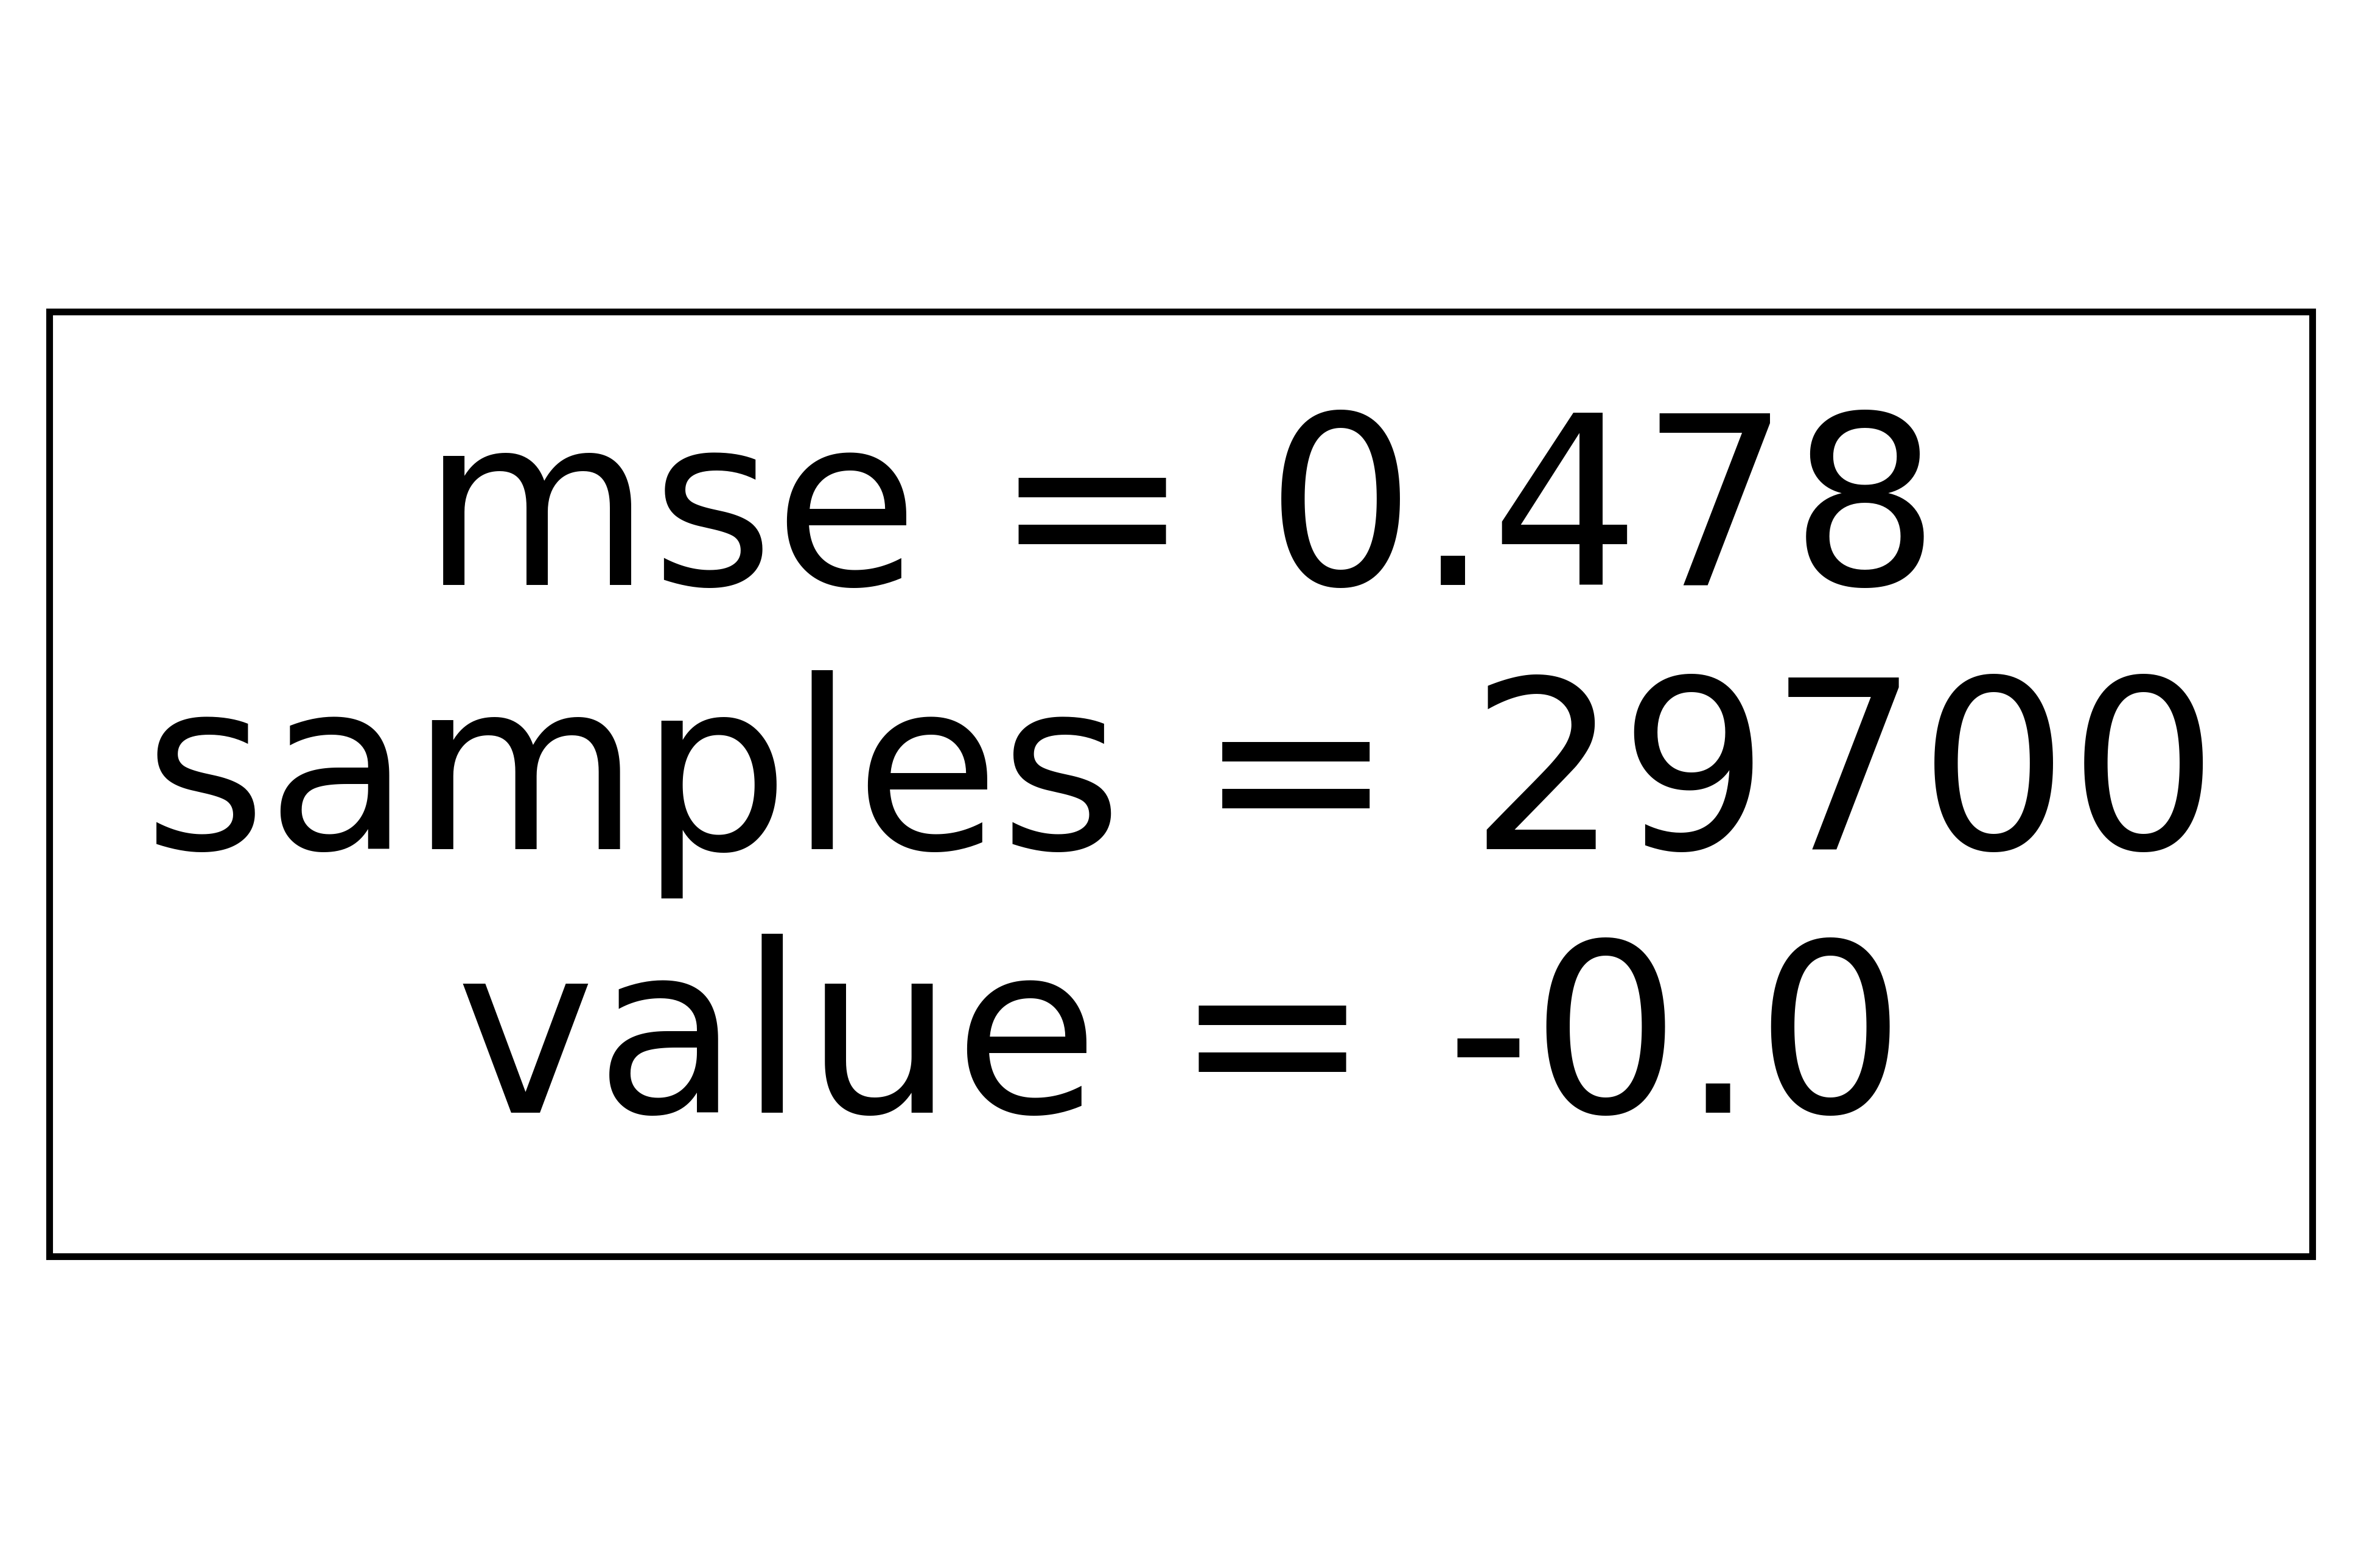

In [253]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=800)
tree.plot_tree(GBM.estimators_[30,0],     # Get the tree number 30
               feature_names = features, 
               class_names=['0','1'],
               filled = True);

## XGB

In [196]:
XGB = XGBClassifier(n_estimators = 50, objective='binary:logistic', booster='gbtree',
                        colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10)

XGB.fit(x_train,y_train)

# Predict Output
XGB_pred = XGB.predict(x_test)

# Accuracy Score on test dataset
XGB_accuracy = accuracy_score(y_test,XGB_pred)
print("Accuracy: %.2f%%" % (XGB_accuracy * 100.0))

XGB_probs = XGB.predict_proba(x_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)
print('\nROC AUC : ', round(XGB_roc_value,2))

Accuracy: 99.48%

ROC AUC :  0.95


### Confusion Matrix

Confusion matrix : 
 [[552823      0]
 [  2896      0]]
Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    368563
           1       0.00      0.01      0.00      1916

    accuracy                           0.93    370479
   macro avg       0.50      0.47      0.48    370479
weighted avg       0.99      0.93      0.96    370479



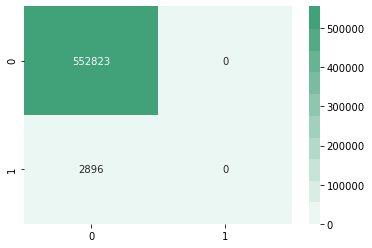

In [301]:
# confusion matrix
XGBmatrix = confusion_matrix(y_test, XGB_pred)
print('Confusion matrix : \n',XGBmatrix)

# classification report for precision, recall f1-score and accuracy
XGBmatrix1 = classification_report(y_test,XGB_pred)
print('Classification report : \n',GBMmatrix1)

cmap =  sns.diverging_palette(180, 150, s=80, l=60, n=20)
sns.heatmap(XGBmatrix, annot=True, fmt=".0f", vmin=0, vmax=555719, center= 0, cmap=cmap)
plt.show()

### Feature Importances

In [198]:
# Extract feature importances
XGB_Feature_Imp = pd.DataFrame({'features': list(features),
                   'importance': XGB.feature_importances_}).\
                    sort_values('importance', ascending = False)
XGB_Feature_Imp.head()

features  importance
5   category_gas_transport    0.618341
7     category_grocery_pos    0.166049
0                      amt    0.068721
3   category_entertainment    0.028389
12       category_misc_pos    0.024620

# Conclusion

According to the accuracies and AUC score, XGB has the best performance.